# Introduction #
Restaurants are constantly looking for ways to cut costs while continue to serve food with the same quality. You can do this by finding efficiencies in labour, production or raw materials. In this project, we will look at a dataset to determine whether we can run a model to more accurately predict when people will order a certain item. If it is completed effectively, this will allow the restaurant to do more accurate purchases. This help save costs by reducing waste and finding sales when making required purchases to meet the demand.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/food-demand/sample_submission.csv
/kaggle/input/food-demand/food_Demand_test.csv
/kaggle/input/food-demand/foodDemand_train/meal_info.csv
/kaggle/input/food-demand/foodDemand_train/fulfilment_center_info.csv
/kaggle/input/food-demand/foodDemand_train/train.csv


In [2]:
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
ful = pd.read_csv('/kaggle/input/food-demand/foodDemand_train/fulfilment_center_info.csv')
meal = pd.read_csv('/kaggle/input/food-demand/foodDemand_train/meal_info.csv')
df = pd.read_csv('/kaggle/input/food-demand/foodDemand_train/train.csv')


In [4]:
ful.head()

,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6


In [5]:
meal.head()

,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian


In [6]:
df.describe()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
count,4.565480e+05,456548.000000,456548.000000,456548.000000,456548.000000,456548.000000,456548.000000,456548.00000,456548.000000
mean,1.250096e+06,74.768771,82.105796,2024.337458,332.238933,354.156627,0.081152,0.10920,261.872760
std,1.443548e+05,41.524956,45.975046,547.420920,152.939723,160.715914,0.273069,0.31189,395.922798
min,1.000000e+06,1.000000,10.000000,1062.000000,2.970000,55.350000,0.000000,0.00000,13.000000
25%,1.124999e+06,39.000000,43.000000,1558.000000,228.950000,243.500000,0.000000,0.00000,54.000000
50%,1.250184e+06,76.000000,76.000000,1993.000000,296.820000,310.460000,0.000000,0.00000,136.000000
75%,1.375140e+06,111.000000,110.000000,2539.000000,445.230000,458.870000,0.000000,0.00000,324.000000
max,1.499999e+06,145.000000,186.000000,2956.000000,866.270000,866.270000,1.000000,1.00000,24299.000000


In [7]:
ful.region_code.nunique()

8

In [8]:
ful.head()

,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6


I merged the columns from all of the datasets to see if there is additional information that can help the model more accurately 

In [9]:
df = df.merge(meal, on='meal_id')

In [10]:
df = df.merge(ful, on='center_id')

In [11]:
df.isna().sum()

id                       0
week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
num_orders               0
category                 0
cuisine                  0
city_code                0
region_code              0
center_type              0
op_area                  0
dtype: int64

## EDA ##
First off I will look at a breakdown of the number unique id's (This can have multiple order per id) broken down by the cuisine. We can see that Beverages are clearly sold the most. In general, beverages would be seen as cheaper than full meals so we would expect to see higher sales of this. The rest of the meals are relatively evenly spread.

<Figure size 1080x1080 with 0 Axes>

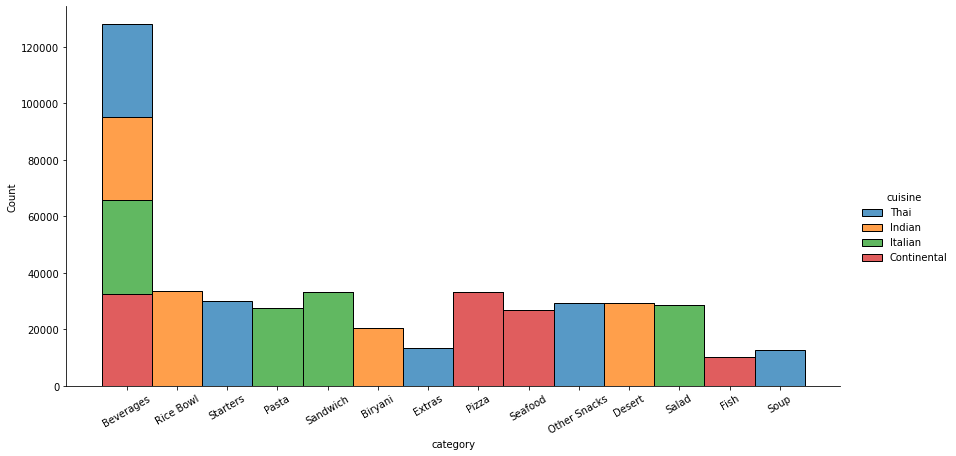

In [12]:
fig = plt.figure(figsize=(15,15))

g = sns.displot(data=df, x='category', hue = 'cuisine',height = 6, aspect = 2, multiple = 'stack')
g.set_xticklabels(rotation=30)
plt.show()

Next, I just wanted to show the average base price of each of the meals. Seafood, Fish and Pizza have the highest price among the meals/categories.

In [13]:
df.groupby(['category'])['base_price'].mean()

category
Beverages       226.854609
Biryani         460.962293
Desert          466.559037
Extras          204.934888
Fish            596.939319
Other Snacks    273.385964
Pasta           428.045511
Pizza           643.765222
Rice Bowl       339.386778
Salad           300.579144
Sandwich        305.233585
Seafood         665.176243
Soup            231.415428
Starters        284.118421
Name: base_price, dtype: float64

In the below graph, we're looking at the total price received by week and cuisine. It's interesting to see that there is such a large discrepancy between the Continental cuisine and the rest of the cuisine's, when it come to the total base_price sold. It would seems the higher priced meals (pizza and seafood) fall under the Continental cuisine. In addition, we can see that total base price drops around the same time among all of the cuisine's (The percentage drops are different among all of the cuisine's).

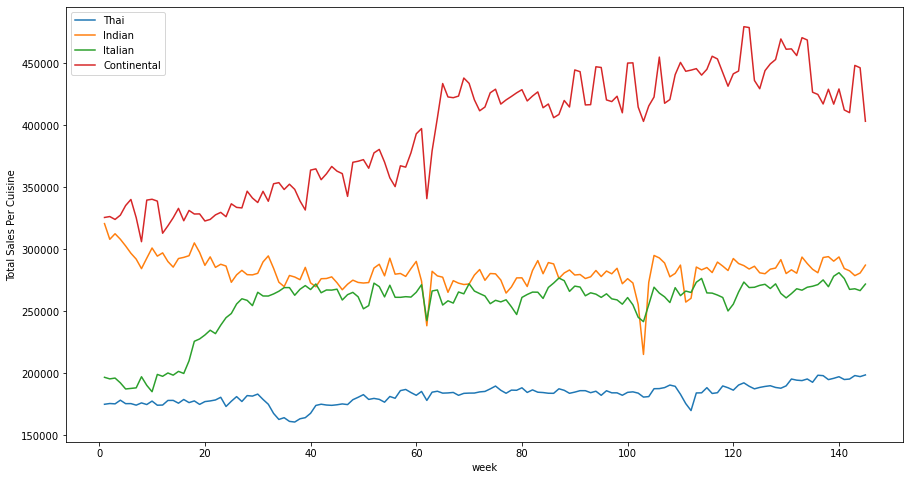

In [14]:
plt.figure(figsize=(15,8))
for typ in list(df['cuisine'].unique()):
    weekwise = df[df['cuisine'] == typ].groupby('week').base_price.sum()
    weekwise.plot()
plt.ylabel('Total Sales Per Cuisine')
plt.legend(list(df['cuisine'].unique()))
plt.show()

In [15]:
top_cont = df[df['cuisine'] == 'Continental'].groupby('category').num_orders.sum()
top_cont

category
Beverages    5943046
Fish          871959
Pizza        7383720
Seafood      2715714
Name: num_orders, dtype: int64

Next, I wanted to see what the price difference is betweent he base and checkout price. This could show whether the total prices are mainly driven by the discount. Thai food seemed to have the most consistent price between the base and checkout price, while the Continental food had the largest difference between the base and checkout price. 

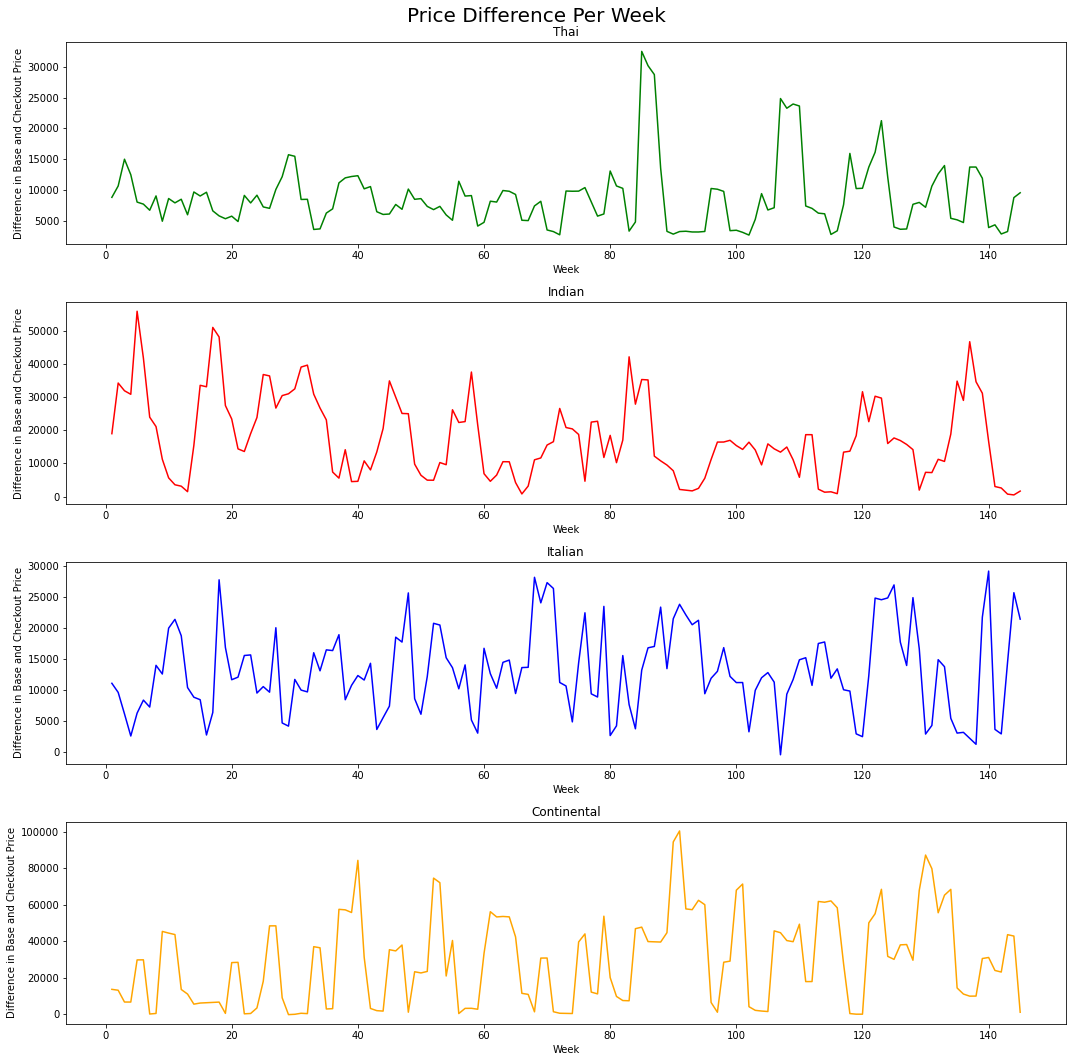

In [16]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (15,15))
subs = [ax1, ax2, ax3, ax4]
color = ['green', 'red', 'blue', 'orange']
for typ, sub, col in zip(list(df['cuisine'].unique()), subs, color):
    weekwise = df[df['cuisine'] == typ].groupby('week').base_price.sum() - df[df['cuisine'] == typ].groupby('week').checkout_price.sum()
    sub.plot(weekwise, color = col)
    sub.set_title(typ)
    sub.set_xlabel('Week')
    sub.set_ylabel('Difference in Base and Checkout Price')
   
fig.suptitle('Price Difference Per Week', fontsize = 20)
fig.subplots_adjust(top=0.90)
plt.xlabel('Week')
fig.tight_layout()
plt.show()

After looking at the price, I wanted to take a look at which categories were the leading the overall number of order. For the graph, I thought it would be reasonable to look at the weekly sales of the top 6 number of orders. The lower cost items were the leaders for the number of orders, with Pizza being the lone higher priced item that made it into the top 6. 

In [17]:
top6 = df.groupby('category').num_orders.sum()
top6

category
Beverages       40480525
Biryani           631848
Desert           1940754
Extras           3984979
Fish              871959
Other Snacks     4766293
Pasta            1637744
Pizza            7383720
Rice Bowl       20874063
Salad           10944336
Sandwich        17636782
Seafood          2715714
Soup             1039646
Starters         4649122
Name: num_orders, dtype: int64

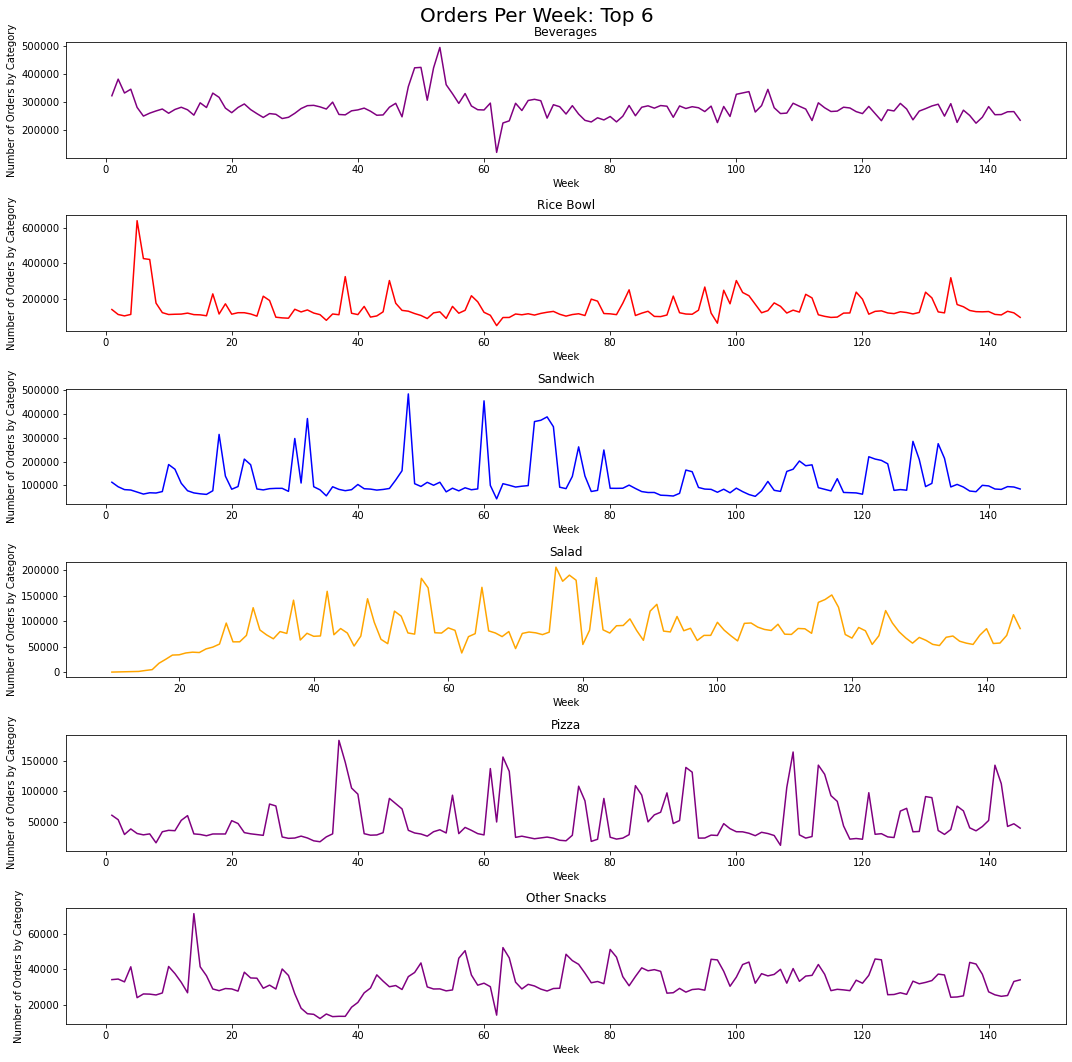

In [18]:
fig, (ax1, ax2, ax3,ax4, ax5,ax6) = plt.subplots(6, figsize = (15,15))
top6 = ['Beverages', 'Rice Bowl', 'Sandwich', 'Salad', 'Pizza', 'Other Snacks']
color = ['purple', 'red', 'blue', 'orange','purple', 'purple']
subs = [ax1,ax2,ax3,ax4,ax5,ax6]
for typ, sub, col in zip(top6, subs, color):
    weekwise = df[df['category'] == typ].groupby('week').num_orders.sum() 
    sub.plot(weekwise, color = col)
    sub.set_title(typ)
    sub.set_xlabel('Week')
    sub.set_ylabel('Number of Orders by Category')
   
fig.suptitle('Orders Per Week: Top 6', fontsize = 20)
fig.subplots_adjust(top=0.90)
plt.xlabel('Week')
fig.tight_layout()
plt.show()

The next graphs that are presented a violin plot showing the density in the Checkout Price by a Promotion on a certain item and whether it has been Featured on the HomePage. In both cases when there was a promotion or featured on the HomePage (1), are mostly congregated around 300 and 500.  

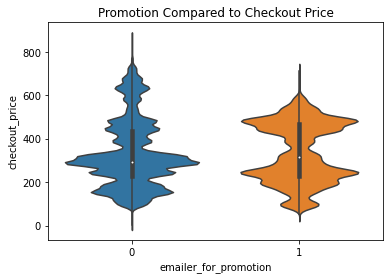

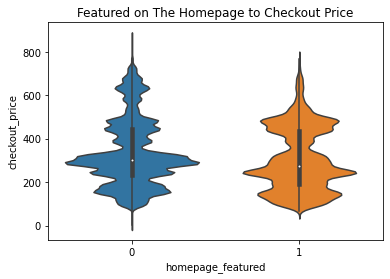

In [19]:
plt.clf()
sns.violinplot(data=df, x='emailer_for_promotion', y= 'checkout_price')
plt.title('Promotion Compared to Checkout Price')

plt.show()
sns.violinplot(data=df, x='homepage_featured', y= 'checkout_price')
plt.title('Featured on The Homepage to Checkout Price')
plt.show()

In [20]:
norm_df = df
norm_df

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,city_code,region_code,center_type,op_area
0,1379560,1,55,1885,136.83,152.29,0,0,177,Beverages,Thai,647,56,TYPE_C,2.0
1,1018704,2,55,1885,135.83,152.29,0,0,323,Beverages,Thai,647,56,TYPE_C,2.0
2,1196273,3,55,1885,132.92,133.92,0,0,96,Beverages,Thai,647,56,TYPE_C,2.0
3,1116527,4,55,1885,135.86,134.86,0,0,163,Beverages,Thai,647,56,TYPE_C,2.0
4,1343872,5,55,1885,146.50,147.50,0,0,215,Beverages,Thai,647,56,TYPE_C,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456543,1437396,141,61,2104,583.03,630.53,0,1,13,Fish,Continental,473,77,TYPE_A,4.5
456544,1060716,142,61,2104,581.03,582.03,0,0,42,Fish,Continental,473,77,TYPE_A,4.5
456545,1029231,143,61,2104,583.03,581.03,0,0,40,Fish,Continental,473,77,TYPE_A,4.5
456546,1141147,144,61,2104,582.03,581.03,0,0,53,Fish,Continental,473,77,TYPE_A,4.5


In order to present a more normally distributed base and checkout price, I took the log of each of the columns.

In [21]:
norm_df['log_check'] = np.log(df['checkout_price'])
norm_df['log_base'] = np.log(df['base_price'])
norm_df

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,city_code,region_code,center_type,op_area,log_check,log_base
0,1379560,1,55,1885,136.83,152.29,0,0,177,Beverages,Thai,647,56,TYPE_C,2.0,4.918739,5.025787
1,1018704,2,55,1885,135.83,152.29,0,0,323,Beverages,Thai,647,56,TYPE_C,2.0,4.911404,5.025787
2,1196273,3,55,1885,132.92,133.92,0,0,96,Beverages,Thai,647,56,TYPE_C,2.0,4.889747,4.897243
3,1116527,4,55,1885,135.86,134.86,0,0,163,Beverages,Thai,647,56,TYPE_C,2.0,4.911625,4.904237
4,1343872,5,55,1885,146.50,147.50,0,0,215,Beverages,Thai,647,56,TYPE_C,2.0,4.987025,4.993828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456543,1437396,141,61,2104,583.03,630.53,0,1,13,Fish,Continental,473,77,TYPE_A,4.5,6.368239,6.446561
456544,1060716,142,61,2104,581.03,582.03,0,0,42,Fish,Continental,473,77,TYPE_A,4.5,6.364802,6.366522
456545,1029231,143,61,2104,583.03,581.03,0,0,40,Fish,Continental,473,77,TYPE_A,4.5,6.368239,6.364802
456546,1141147,144,61,2104,582.03,581.03,0,0,53,Fish,Continental,473,77,TYPE_A,4.5,6.366522,6.364802


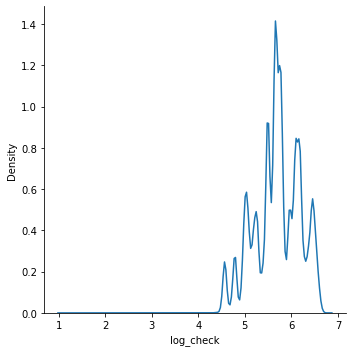

In [22]:
sns.displot(data=norm_df, x='log_check', kind='kde')
plt.show()

## Data Preparation ##
In this section I will be dropping some columns that will no longer be required and normalized.

In [23]:
norm_df = norm_df.drop(['checkout_price', 'base_price', 'center_id', 'meal_id', 'id'], axis=1)

In [24]:
dtyp = []
for col in norm_df.columns[0:]:
    if col == 'num_orders':
        next
    else:
        dtyp.append(col)
dtyp.append('num_orders')
dtyp

['week',
 'emailer_for_promotion',
 'homepage_featured',
 'category',
 'cuisine',
 'city_code',
 'region_code',
 'center_type',
 'op_area',
 'log_check',
 'log_base',
 'num_orders']

In [25]:
norm_df = norm_df[dtyp]

In [26]:
from sklearn import preprocessing

for col in ['op_area', 'log_check', 'log_base']:
    x = np.array(norm_df[col]) #returns a numpy array
    x = np.reshape(x,(-1,1))
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    norm_df[col] = x_scaled

In [27]:
for col in norm_df.columns[:8]:
    norm_df = pd.get_dummies(norm_df, columns=[col], prefix = [col])

In [28]:
target = norm_df.iloc[:,3]

xinfo = norm_df.drop(['num_orders'],axis=1)
xinfo

,op_area,log_check,log_base,week_1,week_2,week_3,week_4,week_5,week_6,week_7,...,region_code_34,region_code_35,region_code_56,region_code_71,region_code_77,region_code_85,region_code_93,center_type_TYPE_A,center_type_TYPE_B,center_type_TYPE_C
0,0.180328,0.674846,0.367970,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,0.180328,0.673553,0.367970,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,0.180328,0.669738,0.321236,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,0.180328,0.673592,0.323779,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
4,0.180328,0.686877,0.356351,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456543,0.590164,0.930235,0.884518,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
456544,0.590164,0.929630,0.855418,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
456545,0.590164,0.930235,0.854793,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
456546,0.590164,0.929933,0.854793,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


In [29]:
#Use the train_test_split to split the data into a training and testing dataset.
from sklearn.model_selection import train_test_split



x_train, x_test, y_train, y_test = train_test_split(xinfo, target, test_size=.2, random_state=10)

## Models ##
I chose to run a couple different linear models, a decision tree and the support vector regressor. After running the linear regression, lasso, SGD Regression and support vector regression model, they resulted in an R sqaured value lower than 50%. The decision tree provides an R squared value of over 70%. 

In [30]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn import svm
from sklearn.linear_model import SGDRegressor

In [39]:
linreg = LinearRegression()
linreg.fit(x_train, y_train)
pre_linear = linreg.predict(x_test)
r_sq = linreg.score(x_test, y_test)
print('Coefficient of determination:', r_sq)

Coefficient of determination: 0.45109750335824117


In [32]:
#Ran a for loop to determine the best tradeoff between number of branches and accuracy of the results
score_list = []

for i in range(2,20):
    decreg = DecisionTreeRegressor(max_depth = i)
    decreg.fit(x_train, y_train)
    pre_tree = decreg.predict(x_test)
    r_sq = decreg.score(x_test, y_test)
    score_list.append(r_sq)

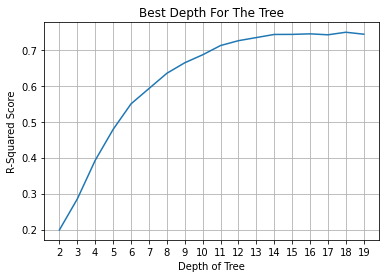

In [33]:
fig = plt.figure()
plt.plot(list(range(2,20)), score_list)
plt.title("Best Depth For The Tree")
plt.xticks(list(range(2,20)))
plt.ylabel("R-Squared Score")
plt.xlabel("Depth of Tree")
plt.grid()
plt.show()

In [34]:
decreg = DecisionTreeRegressor(max_depth = 12)
decreg.fit(x_train, y_train)
r_sq = decreg.score(x_test, y_test)
print('Coefficient of determination:', r_sq)

Coefficient of determination: 0.724788702656802


In [35]:
new_alp = []

for i in np.arange(0.5,5,.5):
    lasreg = Lasso(alpha=i)
    lasreg.fit(x_train, y_train)
    pre_linear = lasreg.predict(x_test)
    r_sq = lasreg.score(x_test, y_test)
    new_alp.append(r_sq)

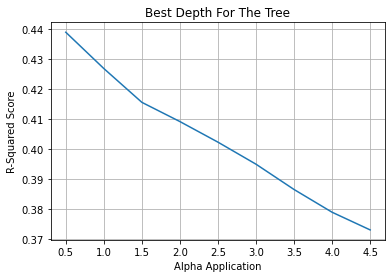

In [36]:
fig = plt.figure()
plt.plot(np.arange(0.5,5,.5), new_alp)
plt.title("Best Depth For The Tree")
plt.xticks(np.arange(0.5,5,.5))
plt.ylabel("R-Squared Score")
plt.xlabel("Alpha Application")
plt.grid()
plt.show()

In [40]:
loss_func = []

for loss in ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']:
    SGDreg = SGDRegressor(loss= loss)
    SGDreg.fit(x_train, y_train)
    pre_SGD = linreg.predict(x_test)
    loss_func.append(pre_SGD)
    r_sq = SGDreg.score(x_test, y_test)
    print('Coefficient of determination:', r_sq)

Coefficient of determination: 0.45057167032937173
Coefficient of determination: 0.033189371435136894
Coefficient of determination: 0.25395740836666036
Coefficient of determination: 0.44994638982368906


In [41]:
for i in range(0,5):
    svreg = svm.LinearSVR(epsilon=i)
    svreg.fit(x_train, y_train)
    pre_svr = svreg.predict(x_test)
    r_sq = svreg.score(x_test, y_test)
    print('Coefficient of determination:', r_sq)

Coefficient of determination: 0.33964629702739435
Coefficient of determination: 0.3391634121155588
Coefficient of determination: 0.3380234045702528
Coefficient of determination: 0.33842490049579665
Coefficient of determination: 0.3392730425758338


## Conclusion ##
Although the decision tree regressor provides a much higher R squared value (accuracy) than the other models, but this would probably be unacceptable for any restaurant to use for determining the number of orders. With an accuracy slightly above 70%, it may be result in some more accurate predictions for future orders, but it may give the user too much confidence in the model. This could result in under investment in the food required, which may not be enough for the demand. When customers start losing trust in a restaurant, it can result in a lot of lost sales in the future.
